# Homework 5  Assignment 4

Prepared by eb3237

## Instructions:

Test if the distribution of 

   1)trip duration of bikers that ride during the day vs night
    
   2)age of bikers for trips originating in Manhattan and in Brooklyn
    
are different. 
    
Use 3 tests: KS, Pearson's, Spearman's. 
    
Use the scipy.stats functions scipy.stats.ks_2samp, scipy.stats.pearsonr, scipy.stats.spearmanr. 
    
    
For the KS do the test with the entire dataset and with a subset 200 times smaller
    
Choose a single significant threshold for the whole exercise. 
    
For each test phrase the Null Hypothesis in words.
    
Describe the return of the scipy function you use in each case.
    
State the result in terms of rejection of the Null.

In [1]:
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import os

%pylab inline

if os.getenv ('PUI2018') is None:
    print ("Must set env variable PUI2018")
if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUIDATA")

import os
import json

Populating the interactive namespace from numpy and matplotlib
Must set env variable PUI2018
Must set env variable PUIDATA


In [2]:
#create the env variable if missing
os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")

print("PUIdata", os.getenv("PUIDATA"))

PUIdata /nfshome/eb3237/PUIdata


In [3]:
#verifying my PUIdata environmental variable 
import os
print("PUIdata", os.getenv("PUIDATA"))

PUIdata /nfshome/eb3237/PUIdata


# Read in data

I am reading in data with the function getCitiBikeCSV. 

You are requested to use 2 months at least. 

It would be a good idea to use data from a colder and a warmer months, since there are more riders in the warm weather and ridership patterns may change with weather, temperature, etc. You should use data from multiple months, joining multiple datasets (thus addressing some systematic errors as well)

=> I am using February and August 2016

In [4]:
#getting citibike data to PUIdata
def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will check that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
                print ("Moved!")
            
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            print ("ok!")
            
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [5]:
#downloading two files as requested
#files description https://www.citibikenyc.com/system-data
#files index https://s3.amazonaws.com/tripdata/index.html

datestring1 = '201602'
datestring2 = '201608'
getCitiBikeCSV(datestring1)
getCitiBikeCSV(datestring2)

file in place, you can continue
file in place, you can continue


In [6]:
#reading downloaded files
# df is the dataframe where the content of the csv file is stored
df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring1 + '-citibike-tripdata.csv')
df2 = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring2 + '-citibike-tripdata.csv')

In [7]:
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,461,2/1/2016 00:00:08,2/1/2016 00:07:49,480,W 53 St & 10 Ave,40.766697,-73.990617,524,W 43 St & 6 Ave,40.755273,-73.983169,23292,Subscriber,1966.0,1
1,297,2/1/2016 00:00:56,2/1/2016 00:05:53,463,9 Ave & W 16 St,40.742065,-74.004432,380,W 4 St & 7 Ave S,40.734011,-74.002939,15329,Subscriber,1977.0,1
2,280,2/1/2016 00:01:00,2/1/2016 00:05:40,3134,3 Ave & E 62 St,40.763126,-73.965269,3141,1 Ave & E 68 St,40.765005,-73.958185,22927,Subscriber,1987.0,1
3,662,2/1/2016 00:01:00,2/1/2016 00:12:02,537,Lexington Ave & E 24 St,40.740259,-73.984092,428,E 3 St & 1 Ave,40.724677,-73.987834,20903,Subscriber,1983.0,2
4,355,2/1/2016 00:01:41,2/1/2016 00:07:36,284,Greenwich Ave & 8 Ave,40.739017,-74.002638,521,8 Ave & W 31 St,40.750967,-73.994442,23228,Subscriber,1978.0,1


In [8]:
df2.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,288,8/1/2016 00:01:22,8/1/2016 00:06:11,302,Avenue D & E 3 St,40.720828,-73.977932,428,E 3 St & 1 Ave,40.724677,-73.987834,16920,Subscriber,1961.0,1
1,457,8/1/2016 00:01:43,8/1/2016 00:09:21,285,Broadway & E 14 St,40.734546,-73.990741,432,E 7 St & Avenue A,40.726218,-73.983799,20084,Subscriber,1989.0,2
2,278,8/1/2016 00:02:10,8/1/2016 00:06:49,539,Metropolitan Ave & Bedford Ave,40.715348,-73.960241,3096,Union Ave & N 12 St,40.719240,-73.952420,18380,Subscriber,1971.0,1
3,862,8/1/2016 00:02:13,8/1/2016 00:16:36,280,E 10 St & 5 Ave,40.733320,-73.995101,280,E 10 St & 5 Ave,40.733320,-73.995101,24101,Subscriber,1995.0,1
4,407,8/1/2016 00:02:21,8/1/2016 00:09:09,161,LaGuardia Pl & W 3 St,40.729170,-73.998102,428,E 3 St & 1 Ave,40.724677,-73.987834,18949,Subscriber,1993.0,1


In [9]:
#append two sets
df.append(df2, ignore_index=True)
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,461,2/1/2016 00:00:08,2/1/2016 00:07:49,480,W 53 St & 10 Ave,40.766697,-73.990617,524,W 43 St & 6 Ave,40.755273,-73.983169,23292,Subscriber,1966.0,1
1,297,2/1/2016 00:00:56,2/1/2016 00:05:53,463,9 Ave & W 16 St,40.742065,-74.004432,380,W 4 St & 7 Ave S,40.734011,-74.002939,15329,Subscriber,1977.0,1
2,280,2/1/2016 00:01:00,2/1/2016 00:05:40,3134,3 Ave & E 62 St,40.763126,-73.965269,3141,1 Ave & E 68 St,40.765005,-73.958185,22927,Subscriber,1987.0,1
3,662,2/1/2016 00:01:00,2/1/2016 00:12:02,537,Lexington Ave & E 24 St,40.740259,-73.984092,428,E 3 St & 1 Ave,40.724677,-73.987834,20903,Subscriber,1983.0,2
4,355,2/1/2016 00:01:41,2/1/2016 00:07:36,284,Greenwich Ave & 8 Ave,40.739017,-74.002638,521,8 Ave & W 31 St,40.750967,-73.994442,23228,Subscriber,1978.0,1


In [10]:
len(df)

560874

In [11]:
df.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')

In [12]:
#delete the fields that I do not need for future analysis
df.drop(['stoptime', 'start station id',
       'start station name', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid'],axis=1, inplace=True)
df.head()

,tripduration,starttime,start station latitude,start station longitude,usertype,birth year,gender
0,461,2/1/2016 00:00:08,40.766697,-73.990617,Subscriber,1966.0,1
1,297,2/1/2016 00:00:56,40.742065,-74.004432,Subscriber,1977.0,1
2,280,2/1/2016 00:01:00,40.763126,-73.965269,Subscriber,1987.0,1
3,662,2/1/2016 00:01:00,40.740259,-73.984092,Subscriber,1983.0,2
4,355,2/1/2016 00:01:41,40.739017,-74.002638,Subscriber,1978.0,1


In [13]:
#filter for only Subscribers 
df = df[(df['usertype'] == 'Subscriber')]
df.head()

,tripduration,starttime,start station latitude,start station longitude,usertype,birth year,gender
0,461,2/1/2016 00:00:08,40.766697,-73.990617,Subscriber,1966.0,1
1,297,2/1/2016 00:00:56,40.742065,-74.004432,Subscriber,1977.0,1
2,280,2/1/2016 00:01:00,40.763126,-73.965269,Subscriber,1987.0,1
3,662,2/1/2016 00:01:00,40.740259,-73.984092,Subscriber,1983.0,2
4,355,2/1/2016 00:01:41,40.739017,-74.002638,Subscriber,1978.0,1




# PART 1. Trip duration of bikers that ride during the day vs night


#### Null Hypothesis: The trip duration distributions between daytime and nighttime are the same. 

#### Other words, there is no statistical difference in the trip duration for trips starting at daytime or nighttime

Significance Level: $\alpha = 0.05$


## SPLIT BY CATEGORY

In [18]:
# note that with dataframes I can refer to variables as dictionary keys, 
# i.e. df['starttime'] or as attributes: df.starttime. 
df['date'] = pd.to_datetime(df['starttime'])
df.head()

,tripduration,starttime,start station latitude,start station longitude,usertype,birth year,gender,date,starthour
0,461,2/1/2016 00:00:08,40.766697,-73.990617,Subscriber,1966.0,1,2016-02-01 00:00:08,0
1,297,2/1/2016 00:00:56,40.742065,-74.004432,Subscriber,1977.0,1,2016-02-01 00:00:56,0
2,280,2/1/2016 00:01:00,40.763126,-73.965269,Subscriber,1987.0,1,2016-02-01 00:01:00,0
3,662,2/1/2016 00:01:00,40.740259,-73.984092,Subscriber,1983.0,2,2016-02-01 00:01:00,0
4,355,2/1/2016 00:01:41,40.739017,-74.002638,Subscriber,1978.0,1,2016-02-01 00:01:41,0


In [19]:
df['starthour'] = df['date'].dt.hour
df.head()

,tripduration,starttime,start station latitude,start station longitude,usertype,birth year,gender,date,starthour
0,461,2/1/2016 00:00:08,40.766697,-73.990617,Subscriber,1966.0,1,2016-02-01 00:00:08,0
1,297,2/1/2016 00:00:56,40.742065,-74.004432,Subscriber,1977.0,1,2016-02-01 00:00:56,0
2,280,2/1/2016 00:01:00,40.763126,-73.965269,Subscriber,1987.0,1,2016-02-01 00:01:00,0
3,662,2/1/2016 00:01:00,40.740259,-73.984092,Subscriber,1983.0,2,2016-02-01 00:01:00,0
4,355,2/1/2016 00:01:41,40.739017,-74.002638,Subscriber,1978.0,1,2016-02-01 00:01:41,0


In [20]:
#trips starting at or after 6am and ending at 8 pm (daytime) 
#trips starting at or after 8pm and ending at 6 am (nighttime)

df['day_night'] = np.where((df['starthour'] > 6)&(df['starthour'] < 20), 'day', 'night')
df.head()

,tripduration,starttime,start station latitude,start station longitude,usertype,birth year,gender,date,starthour,day_night
0,461,2/1/2016 00:00:08,40.766697,-73.990617,Subscriber,1966.0,1,2016-02-01 00:00:08,0,night
1,297,2/1/2016 00:00:56,40.742065,-74.004432,Subscriber,1977.0,1,2016-02-01 00:00:56,0,night
2,280,2/1/2016 00:01:00,40.763126,-73.965269,Subscriber,1987.0,1,2016-02-01 00:01:00,0,night
3,662,2/1/2016 00:01:00,40.740259,-73.984092,Subscriber,1983.0,2,2016-02-01 00:01:00,0,night
4,355,2/1/2016 00:01:41,40.739017,-74.002638,Subscriber,1978.0,1,2016-02-01 00:01:41,0,night


In [21]:
#grouping days and nights
grouped = df.groupby('day_night')

In [22]:
#getting two dataframes separately for day and night
days = grouped.get_group('day')
nights = grouped.get_group('night')
days.head()

,tripduration,starttime,start station latitude,start station longitude,usertype,birth year,gender,date,starthour,day_night
1282,1031,2/1/2016 07:00:00,40.777507,-73.988886,Subscriber,1968.0,1,2016-02-01 07:00:00,7,day
1283,196,2/1/2016 07:00:05,40.771404,-73.953517,Subscriber,1988.0,1,2016-02-01 07:00:05,7,day
1284,351,2/1/2016 07:00:06,40.736494,-73.997044,Subscriber,1987.0,1,2016-02-01 07:00:06,7,day
1285,1513,2/1/2016 07:00:12,40.733143,-73.975739,Subscriber,1987.0,1,2016-02-01 07:00:12,7,day
1286,988,2/1/2016 07:00:13,40.689888,-73.981013,Subscriber,1958.0,2,2016-02-01 07:00:13,7,day


In [23]:
days.describe()

,tripduration,start station latitude,start station longitude,birth year,gender,starthour
count,4.481060e+05,448106.000000,448106.000000,448105.00000,448106.000000,448106.000000
mean,7.891010e+02,40.737736,-73.986978,1976.11662,1.215570,13.260126
std,6.264990e+03,0.021235,0.015123,11.85575,0.417112,3.962009
min,6.100000e+01,40.678907,-74.017134,1885.00000,0.000000,7.000000
25%,3.310000e+02,40.723117,-73.997236,1968.00000,1.000000,9.000000
50%,5.170000e+02,40.739355,-73.988484,1978.00000,1.000000,14.000000
75%,8.260000e+02,40.751873,-73.977910,1986.00000,1.000000,17.000000
max,1.811478e+06,40.787209,-73.929891,2000.00000,2.000000,19.000000


In [24]:
nights.head()

,tripduration,starttime,start station latitude,start station longitude,usertype,birth year,gender,date,starthour,day_night
0,461,2/1/2016 00:00:08,40.766697,-73.990617,Subscriber,1966.0,1,2016-02-01 00:00:08,0,night
1,297,2/1/2016 00:00:56,40.742065,-74.004432,Subscriber,1977.0,1,2016-02-01 00:00:56,0,night
2,280,2/1/2016 00:01:00,40.763126,-73.965269,Subscriber,1987.0,1,2016-02-01 00:01:00,0,night
3,662,2/1/2016 00:01:00,40.740259,-73.984092,Subscriber,1983.0,2,2016-02-01 00:01:00,0,night
4,355,2/1/2016 00:01:41,40.739017,-74.002638,Subscriber,1978.0,1,2016-02-01 00:01:41,0,night


In [25]:
nights.describe()

,tripduration,start station latitude,start station longitude,birth year,gender,starthour
count,8.294300e+04,82943.000000,82943.000000,82943.000000,82943.000000,82943.000000
mean,7.084334e+02,40.736546,-73.986770,1978.202428,1.177749,15.377295
std,5.964676e+03,0.020992,0.015146,11.607814,0.387067,8.145287
min,6.100000e+01,40.678907,-74.017134,1885.000000,0.000000,0.000000
25%,2.980000e+02,40.722281,-73.996924,1970.000000,1.000000,6.000000
50%,4.640000e+02,40.737050,-73.989151,1981.000000,1.000000,20.000000
75%,7.345000e+02,40.751102,-73.979661,1987.000000,1.000000,21.000000
max,1.011111e+06,40.787209,-73.929891,1999.000000,2.000000,23.000000


The next several steps are needed if you want to code up the KS test from scratch. that is for extra credit, so if you do not want to do it you may not need to plot split the distribution in bins and create the cumulative HOWEVER it is a great idea to do it anyways to explore your data viaually! remember Ascombe's quartet!!

Lets split trip duration in 150 BINS. the dataset is very large, so i could be split in smaller bins, but I will chose 150 to try.  

The bin size choice should be a balance between properly sample the age space, have enough counts in each bin that the statistical noise is not significant (remember that is > sqrt(N)!) and the computational requirement to computatinal facilities ratio.

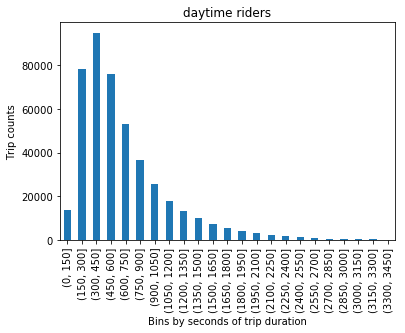

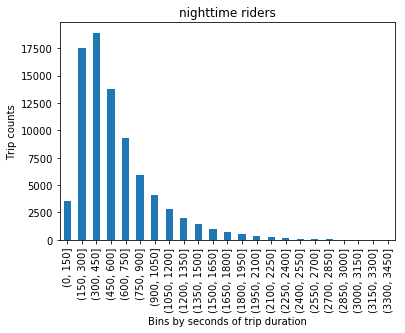

In [26]:
# plotting histogramswith pandas is a bitdifferent than with pylab
# this is a VERY USEFUL syntaxfor you to knonw!

bins = np.arange(0, 3600, 150)
axD = days.tripduration.groupby(pd.cut(days.tripduration, bins)).agg([count_nonzero]).plot(kind='bar',
                                                                legend=False)
axD.set_title("daytime riders")
axD.set_xlabel("Bins by seconds of trip duration")
axD.set_ylabel("Trip counts")

axN = nights.tripduration.groupby(pd.cut(nights.tripduration, bins)).agg([count_nonzero]).plot(kind='bar',
                                                                legend=False)
axN.set_title("nighttime riders")
axN.set_xlabel("Bins by seconds of trip duration")
axN.set_ylabel("Trip counts")

**Figure 1: histogrammed distribution of trip duration by day and night time **



this is how the cumulative distributions look like.  Notice that i am normalizing them! if i want to reat an observed distribution like a probablility distribution i have to normalize it

              count_nonzero
tripduration               
(0, 150]           0.012221
(150, 300]         0.047494
(300, 450]         0.063296
(450, 600]         0.059725
(600, 750]         0.053648
(750, 900]         0.042697
(900, 1050]        0.034476
(1050, 1200]       0.028933
(1200, 1350]       0.022976
(1350, 1500]       0.018718
(1500, 1650]       0.014382
(1650, 1800]       0.010370
(1800, 1950]       0.007934
(1950, 2100]       0.005871
(2100, 2250]       0.004247
(2250, 2400]       0.003014
(2400, 2550]       0.001734
(2550, 2700]       0.001268
(2700, 2850]       0.000916
(2850, 3000]       0.000552
(3000, 3150]       0.000301
(3150, 3300]       0.000168
(3300, 3450]       0.000000


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ucsl17_python3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


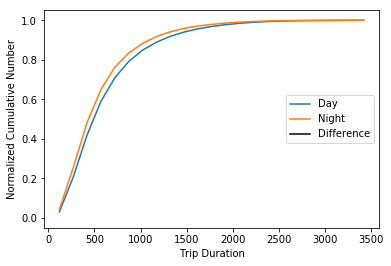

In [27]:
csD = days.tripduration.groupby(pd.cut(days.tripduration, bins)).agg([count_nonzero]).cumsum()
csN = nights.tripduration.groupby(pd.cut(nights.tripduration, bins)).agg([count_nonzero]).cumsum()

print(np.abs(csD / csD.max() - csN / csN.max()))

pl.plot(bins[:-1] + 120, csD / csD.max(), label = "Day")
pl.plot(bins[:-1] + 120, csN / csN.max(), label = "Night")
pl.plot(bins[:-1] + 120, np.sqrt(csD / csD.max() - csN / csN.max())**2, 'k-', label = "Difference")
pl.xlabel("Trip Duration")
pl.ylabel("Normalized Cumulative Number")
pl.legend()

** Figure 2: the cumulative distribution of CitiBike riders' trip durations by day and night** They look very similar

# KS tests to compare 2 samples - Daytime and Nighttime

http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.ks_2samp.html

the KS test in scipy returns the p-value BUT make sure you understand what the NULL is! read the documentation carefully! what is the null hypothesis that you can/cannot reject?

#### Null Hypothesis: The trip duration distributions between daytime and nighttime are not the same distributions. 


Significance Level: $\alpha = 0.05$

In [28]:
#converting day/night dataframes into arrays for KS analysis
val_days = days['tripduration'].values
val_nights = nights['tripduration'].values

In [29]:
import scipy.stats
ks = scipy.stats.ks_2samp(val_days, val_nights)
print(ks)

Ks_2sampResult(statistic=0.064667590465006031, pvalue=7.0354862375273548e-255)


Below I state what the scipy KS test returned and what it means in terms of NULL HYPOTHESIS. 

To do that I refer to the scipy documentation to understand the output of the scipy.stats.ks_2samp function.

It Computes the Kolmogorov-Smirnov statistic on 2 samples.
This is a two-sided test for the null hypothesis that 2 independent samples are drawn from the same continuous distribution.



The KS statistic is 0.064667590465006031, which mean distance between the cumulative distribution function of the day and the night riders is very small. KS 2-sample test's null hypothesis is that the two distributions are the same, and that specific null hypothesis can only be rejected if the statistic is greater than the value of $c(\alpha)$. 

Looking at the table value, where ($\alpha$) = 0.05, c($\alpha$) should be > 1.36 to reject the Null hypothesis. 


#### So we cannot reject the null hypothesis that the 2 distributions are not statistically different.



# KS tests to compare 2 subsamples  / 200 times smaller - Daytime and Nighttime

#### Null Hypothesis: The trip duration distributions between daytime and nighttime are the same. 

In [30]:
#redusing the size by 200 times and creating new subsets
sub_val_days = (len(days)/200)
sub_val_nights = (len(nights)/200)

sub_val_days = days.sample(int(sub_val_days), random_state = 5)
sub_val_nights = nights.sample(int(sub_val_nights), random_state = 5)

In [31]:
#converting dataframes into arrays for KS analysis
sub_val_days = sub_val_days['tripduration'].values
sub_val_nights = sub_val_nights['tripduration'].values

In [32]:
scipy.stats.ks_2samp(sub_val_days, sub_val_nights)

Ks_2sampResult(statistic=0.093223775017253319, pvalue=0.004243722626957153)


#### Results from the above analysis show that the pvalue is  low. Therefore, assuming  alpha value of 0.05, we can reject the null hypothesis

# Pearson's  test for correlation

** notice that the Pearson's is a pairwise test: the samples need to be **
 
 a. the same size
 
 b. sorted! 
    
http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html#scipy.stats.pearsonr



In [33]:
#taking 1/200th samples as numpy arrays to get data the same size

#using random seed
np.random.seed(99)

#using .choice funciton
days_array = np.random.choice(days['tripduration'], size = 20000, replace=False)
nights_array = np.random.choice(nights['tripduration'], size = 20000, replace = False)

In [34]:
#Sort arrays to prep for Pearson's and Spearman's Correlation tests:
days_array = np.sort(days_array)
nights_array = np.sort(nights_array)

In [35]:
#Pearson Test
Ppearson=scipy.stats.pearsonr(days_array, nights_array)
print(Ppearson)

(0.96342069791057272, 0.0)



#### Results from the above analysis show that the pvalue is  low. Therefore, assuming  alpha value of 0.05, we can reject the null hypothesis

# Spearman's  test for correlation

http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html#scipy.stats.spearmanr

In [36]:
scipy.stats.spearmanr(days_array, nights_array)

SpearmanrResult(correlation=0.99999870184843753, pvalue=0.0)


#### Results from the above analysis show that the pvalue is  low. Therefore, assuming  alpha value of 0.05, we can reject the null hypothesis



# PART 2. Age of bikers for trips originating in Manhattan and in Brooklyn


**H0: there is no statistical difference in the age distribution of trips originating in Manhattan and Brooklyn**
$$ \alpha = 0.05 $$


## SPLIT BY CATEGORY 

In [37]:
#Determining Boundaries of Boroughs 
#Assumption:  I am udsing Google map to manually determine the boundaries and 
#I assume that they are correct for my analysis, although some trips may not be included because of that determination

# MANHATTAN BOUNDARIES

#lower par Manhattan
#40.702226, -74.012867

#upper manhattan
#40.829379, -73.940431

#left (west) manhattan
#40.757121, -74.003436

#right (east) manhattan
#40.774673, -73.944647

#Manhattan
df.loc[(df['start station latitude'] < 40.829379)
       & (df['start station latitude'] > 40.702226)
       & (df['start station longitude'] < -73.944647)
       & (df['start station longitude'] > -74.003436), 
       'borough'] = 'Manhattan'

#BROOKLYN BOUNDATIES
#left 
#40.634129, -74.037693

#right
#40.663694, -73.895959

#upper
#40.702226, -74.012867

#lower
#40.576655, -73.967403

#Brooklyn
df.loc[(df['start station latitude'] < 40.702226)
       & (df['start station latitude'] > 40.576655)
       & (df['start station longitude'] < -73.967403)
       & (df['start station longitude'] > -74.037693), 
       'borough'] = 'Brooklyn'

df.head()

,tripduration,starttime,start station latitude,start station longitude,usertype,birth year,gender,date,starthour,day_night,borough
0,461,2/1/2016 00:00:08,40.766697,-73.990617,Subscriber,1966.0,1,2016-02-01 00:00:08,0,night,Manhattan
1,297,2/1/2016 00:00:56,40.742065,-74.004432,Subscriber,1977.0,1,2016-02-01 00:00:56,0,night,NaN
2,280,2/1/2016 00:01:00,40.763126,-73.965269,Subscriber,1987.0,1,2016-02-01 00:01:00,0,night,Manhattan
3,662,2/1/2016 00:01:00,40.740259,-73.984092,Subscriber,1983.0,2,2016-02-01 00:01:00,0,night,Manhattan
4,355,2/1/2016 00:01:41,40.739017,-74.002638,Subscriber,1978.0,1,2016-02-01 00:01:41,0,night,Manhattan


In [38]:
df['borough'].dropna(inplace= True)

In [39]:
df.columns

Index(['tripduration', 'starttime', 'start station latitude',
       'start station longitude', 'usertype', 'birth year', 'gender', 'date',
       'starthour', 'day_night', 'borough'],
      dtype='object')

In [40]:
df.drop(['tripduration', 'starttime', 'start station latitude',
       'start station longitude',
        'usertype', 'gender', ],axis=1, inplace=True)
df.head()

,birth year,date,starthour,day_night,borough
0,1966.0,2016-02-01 00:00:08,0,night,Manhattan
1,1977.0,2016-02-01 00:00:56,0,night,NaN
2,1987.0,2016-02-01 00:01:00,0,night,Manhattan
3,1983.0,2016-02-01 00:01:00,0,night,Manhattan
4,1978.0,2016-02-01 00:01:41,0,night,Manhattan


In [41]:
#creating a column with ages - extracting the age happens in the cell below
df['age'] = 2018 - df['birth year']
df.head()

,birth year,date,starthour,day_night,borough,age
0,1966.0,2016-02-01 00:00:08,0,night,Manhattan,52.0
1,1977.0,2016-02-01 00:00:56,0,night,NaN,41.0
2,1987.0,2016-02-01 00:01:00,0,night,Manhattan,31.0
3,1983.0,2016-02-01 00:01:00,0,night,Manhattan,35.0
4,1978.0,2016-02-01 00:01:41,0,night,Manhattan,40.0


In [42]:
#getting two dataframes for two boroughs

#Manhattan
mh_df = df[df['borough'] == 'Manhattan']
mh_df.head()

,birth year,date,starthour,day_night,borough,age
0,1966.0,2016-02-01 00:00:08,0,night,Manhattan,52.0
2,1987.0,2016-02-01 00:01:00,0,night,Manhattan,31.0
3,1983.0,2016-02-01 00:01:00,0,night,Manhattan,35.0
4,1978.0,2016-02-01 00:01:41,0,night,Manhattan,40.0
5,1966.0,2016-02-01 00:01:44,0,night,Manhattan,52.0


In [43]:
mh_df.describe()

,birth year,starthour,age
count,427992.000000,427993.000000,427992.000000
mean,1976.478871,13.544530,41.521129
std,11.907707,4.934515,11.907707
min,1885.000000,0.000000,18.000000
25%,1968.000000,9.000000,32.000000
50%,1979.000000,14.000000,39.000000
75%,1986.000000,18.000000,50.000000
max,2000.000000,23.000000,133.000000


In [44]:
#Brooklyn
br_df = df[df['borough'] == 'Brooklyn']
br_df.head()

,birth year,date,starthour,day_night,borough,age
13,1985.0,2016-02-01 00:04:12,0,night,Brooklyn,33.0
71,1988.0,2016-02-01 00:27:02,0,night,Brooklyn,30.0
72,1983.0,2016-02-01 00:27:05,0,night,Brooklyn,35.0
83,1983.0,2016-02-01 00:29:07,0,night,Brooklyn,35.0
99,1976.0,2016-02-01 00:39:10,0,night,Brooklyn,42.0


In [45]:
br_df.describe()

,birth year,starthour,age
count,22101.000000,22101.000000,22101.000000
mean,1976.364237,13.459210,41.635763
std,11.260233,5.027933,11.260233
min,1885.000000,0.000000,19.000000
25%,1970.000000,9.000000,33.000000
50%,1979.000000,14.000000,39.000000
75%,1985.000000,18.000000,48.000000
max,1999.000000,23.000000,133.000000


# KS tests to compare 2 samples - Manhattan and in Brooklyn

http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.ks_2samp.html

the KS test in scipy returns the p-value BUT make sure you understand what the NULL is! read the documentation carefully! what is the null hypothesis that you can/cannot reject?

In [51]:
#converting dataframes into arrays for KS analysis
val_mh_df = mh_df['age'].values
val_br_df = br_df['age'].values

In [52]:
ks = scipy.stats.ks_2samp(val_mh_df, val_br_df)
print(ks)

Ks_2sampResult(statistic=0.061764963540330536, pvalue=3.5264015913778733e-70)


#### Results from the above analysis show that the pvalue is  low. Therefore, assuming  alpha value of 0.05, we can reject the null hypothesis

# KS tests to compare 2 subsamples  / 200 times smaller - Manhattan and in Brooklyn

#### Null Hypothesis: Manhattan and in Brooklyn distributions are the same. 

In [53]:
#redusing the size by 200 times and creating new subsets
sub_val_mh_df = (len(mh_df)/200)
sub_val_br_df = (len(br_df)/200)

sub_val_mh_df = mh_df.sample(int(sub_val_mh_df), random_state = 5)
sub_val_br_df = br_df.sample(int(sub_val_br_df), random_state = 5)

In [54]:
#converting dataframes into arrays for KS analysis
sub_val_mh_df = sub_val_mh_df['age'].values
sub_val_br_df = sub_val_br_df['age'].values

In [55]:
scipy.stats.ks_2samp(sub_val_mh_df, sub_val_br_df)

Ks_2sampResult(statistic=0.065595647923838651, pvalue=0.74501154504124534)

#### Results from the above analysis show that the pvalue is  low. Therefore, assuming  alpha value of 0.05, we can reject the null hypothesis

# Pearson's  test for correlation

** notice that the Pearson's is a pairwise test: the samples need to be **
 
 a. the same size
 
 b. sorted! 
    
http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html#scipy.stats.pearsonr



In [56]:
#taking 1/200th samples as numpy arrays to get data the same size

#using random seed
np.random.seed(99)

#using .choice funciton
mh_array = np.random.choice(mh_df['age'], size = 20000, replace=False)
br_array = np.random.choice(br_df['age'], size = 20000, replace = False)

In [57]:
#Sort arrays to prep for Pearson's and Spearman's Correlation tests:
mh_array = np.sort(mh_array)
br_array = np.sort(br_array)

In [58]:
#Pearson Test
Ppearson=scipy.stats.pearsonr(mh_array, br_array)
print(Ppearson)

(0.98857885233640086, 0.0)


#### Results from the above analysis show that the pvalue is  low. Therefore, assuming  alpha value of 0.05, we can reject the null hypothesis

# Spearman's  test for correlation

http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html#scipy.stats.spearmanr

In [59]:
scipy.stats.spearmanr(mh_array, br_array)

SpearmanrResult(correlation=0.99911397705276739, pvalue=0.0)

#### Results from the above analysis show that the pvalue is  low. Therefore, assuming  alpha value of 0.05, we can reject the null hypothesis